# The QP-SVM Primal Challenge:
# Optimizing and Visualizing theSoft-Margin Hyperplane SVM

## 1. Data Preprocessing:

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/Social_Network_Ads.csv")
print(df.head())

   Age  EstimatedSalary  Purchased
0   19            19000          0
1   35            20000          0
2   26            43000          0
3   27            57000          0
4   19            76000          0


In [9]:
X = df[['Age', 'EstimatedSalary']].values

y = df['Purchased'].map({0: -1, 1: 1}).values


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()

# Fit scaler to the training data ONLY and then transform X_train
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler (DO NOT fit on test data)
# because of preventing from data leakage
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

print("\n--- Scaled Training Features (First 5 rows) ---")
print(X_train_scaled[:5])

print("\n--- Scaled Test Features (5 rows) ---")
print(X_test_scaled[:5])

X_train_scaled shape: (280, 2)
y_train shape: (280,)

--- Scaled Training Features (First 5 rows) ---
[[-0.95412576 -0.35403293]
 [ 0.36052204 -0.29658337]
 [ 0.17271521  1.48435309]
 [-0.48460869  1.34072919]
 [-1.61144966 -1.35940029]]

--- Scaled Test Features (5 rows) ---
[[ 1.95688008 -0.92852857]
 [-0.29680186 -0.78490466]
 [ 2.14468691  1.08220615]
 [ 0.07881179  0.01938923]
 [ 0.83003911 -0.84235422]]


## 2. QP Formulation and Solution (using cvxpy):

In [15]:
import cvxpy as cp

n_samples, n_features = X_train_scaled.shape
C = 1.0
w = cp.Variable(n_features)

b = cp.Variable()
xi = cp.Variable(n_samples)


In [16]:
#  ||w||^2 + C * sum(xi)
objective = cp.Minimize(0.5 * cp.sum_squares(w) + C * cp.sum(xi))

constraints = [

    cp.multiply(y_train, (X_train_scaled @ w + b)) >= 1 - xi,

    xi >= 0
]

prob = cp.Problem(objective, constraints)

prob.solve()

if prob.status == cp.OPTIMAL or prob.status == cp.OPTIMAL_INACCURATE:
    print("\nQP Problem solved successfully!")

    w_star = w.value
    b_star = b.value

    print("\n--- Optimal Parameters (w* and b*) ---")
    print(f"Optimal w* (Weights): {w_star}")
    print(f"Optimal b* (Bias): {b_star:.4f}")

else:
    print(f"\nProblem did not solve optimally. Status: {prob.status}")


QP Problem solved successfully!

--- Optimal Parameters (w* and b*) ---
Optimal w* (Weights): [1.68213998 1.01520715]
Optimal b* (Bias): -0.9117


## 3. Model Evaluation:

In [20]:
from sklearn.metrics import accuracy_score
import numpy as np


decision_function_output = np.dot(X_test_scaled, w_star) + b_star

y_pred = np.sign(decision_function_output)

print("\n--- Predictions (y_pred) ---\n")
print(y_pred)


--- Predictions (y_pred) ---

[ 1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1. -1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.
 -1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.
  1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1.
 -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [22]:
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy on the test set: {accuracy * 100:.2f}%")


Accuracy on the test set: 83.33%


## 4. Final Deliverable: Visualizing the Decision Boundary

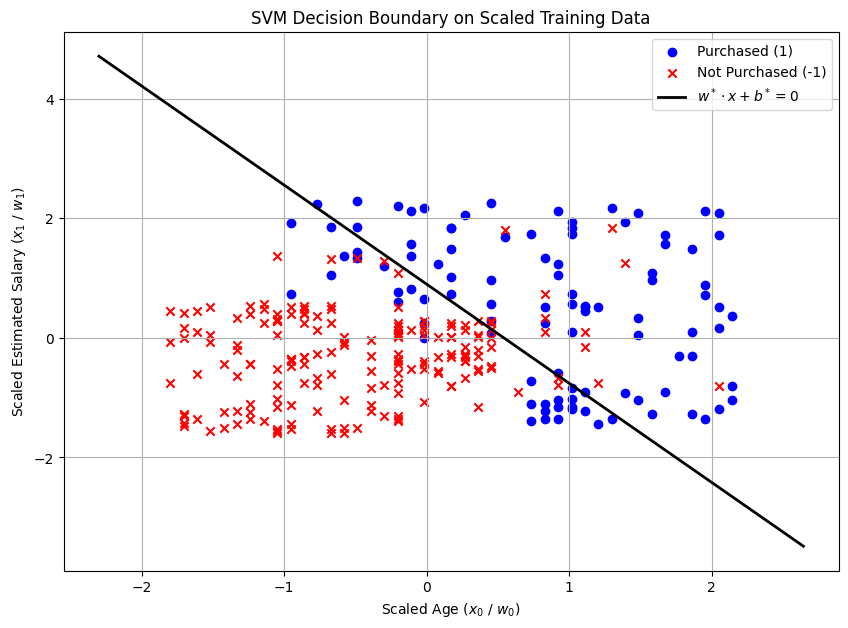

In [23]:
import matplotlib.pyplot as plt

w0 = w_star[0]
w1 = w_star[1]

# Create a range of x0 values (Scaled Age) based on the min/max of the training data
x0_min = X_train_scaled[:, 0].min() - 0.5
x0_max = X_train_scaled[:, 0].max() + 0.5
x0_range = np.linspace(x0_min, x0_max, 100)

# Calculate the corresponding x1 values for the decision boundary line
x1_boundary = (-b_star - w0 * x0_range) / w1


plt.figure(figsize=(10, 7))
plt.title('SVM Decision Boundary on Scaled Training Data')


class_1_indices = y_train == 1
plt.scatter(X_train_scaled[class_1_indices, 0], X_train_scaled[class_1_indices, 1],
            color='blue', marker='o', label='Purchased (1)')

class_minus1_indices = y_train == -1
plt.scatter(X_train_scaled[class_minus1_indices, 0], X_train_scaled[class_minus1_indices, 1],
            color='red', marker='x', label='Not Purchased (-1)')

plt.plot(x0_range, x1_boundary, 'k-', linewidth=2, label=r'$w^* \cdot x + b^* = 0$')

# Label axes
plt.xlabel('Scaled Age ($x_0$ / $w_0$)')
plt.ylabel('Scaled Estimated Salary ($x_1$ / $w_1$)')
plt.legend()
plt.grid(True)
plt.show()